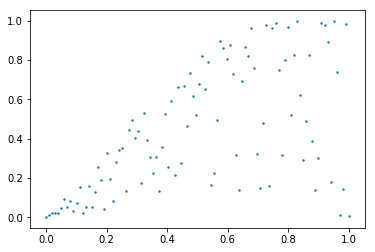

In [160]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

# Data
n = 100
x = np.linspace(0,1,n)
epis = np.random.uniform(-1,1,n)
y = np.sin(x + epis * (x/1)**1.1)

plt.scatter(x, y, s = 2)

In [161]:
x = x.reshape(n, 1)
x.shape

(100, 1)

## Non-Bayesian

In [162]:
# Network parameter
n_inputs = 1
n_hidden1 = 100
n_hidden2 = 50
n_outputs = 1

# tf Graph input
X_tf = tf.placeholder(tf.float32,
                  shape = (None, n_inputs),
                  name = 'X')
y_tf = tf.placeholder(tf.float32,
                  shape = (None),
                  name = 'y')

# Paraameters
learning_rate = 0.1
num_steps = 4000
batch_size = 100
display_step = 500

# Layer weights and bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_inputs, n_hidden1])),
    'h2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_hidden2, n_outputs])), 
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden1])),
    'b2': tf.Variable(tf.random_normal([n_hidden2])),
    'out': tf.Variable(tf.random_normal([n_outputs])), 
}

# Model
def neural_net(x):
    # Hidden fully connected
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    #layer_1 = tf.nn.dropout(layer_1, keep_prob=0.8)
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    #layer_2 = tf.nn.dropout(layer_2, keep_prob=0.8)
    # Output
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    
    return out_layer

In [163]:
# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model

# Initialize the variables
init = tf.global_variables_initializer()

In [164]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        #batch_x = np.random.choice(x[:,0], batch_size).reshape(batch_size, 1)
        #batch_y = np.random.choice(y, batch_size)
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred = sess.run(NN, feed_dict={X_tf: x})


step 1, Minibatch Loss = 11235.253
step 500, Minibatch Loss = 0.055523153
step 1000, Minibatch Loss = 0.053400226
step 1500, Minibatch Loss = 0.05281122
step 2000, Minibatch Loss = 0.052576803
step 2500, Minibatch Loss = 0.052389745
step 3000, Minibatch Loss = 0.05236649
step 3500, Minibatch Loss = 0.05251885
step 4000, Minibatch Loss = 0.05237188
optimization finished


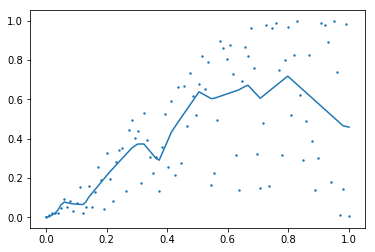

In [165]:
plt.scatter(x, y, s = 2)
plt.plot(x, pred)


## Bayesian

In [177]:
neural_net = tf.keras.Sequential([
    tfp.layers.DenseFlipout(100, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(50, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(1),
])

# Construct model
NN = neural_net(X_tf)

# Define loss function and optimizer
loss_op = tf.losses.mean_squared_error(labels = y_tf,
                                        predictions = tf.transpose(NN))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables
init = tf.global_variables_initializer()

In [178]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    for step in range(1, num_steps+1):
        batch_x = x
        batch_y = y
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
        if step % display_step == 0 or step == 1:
            # Calcualte batch loss and accuracy
            loss = sess.run(loss_op, feed_dict={X_tf: batch_x, y_tf: batch_y})
            print("step " + str(step) + ", Minibatch Loss = " + str(loss))
    
    print("optimization finished")
    
    pred_mean = sess.run(NN, feed_dict={X_tf: x})
    
    # Draw sample for the weights and bias from the posterior
    w0_draw = []
    w1_draw = []
    w2_draw = []
    b0_draw = []
    b1_draw = []
    b2_draw = []
    for i in range(5):
        w0_draw.append(neural_net.layers[0].kernel_posterior.sample().eval())
        w1_draw.append(neural_net.layers[1].kernel_posterior.sample().eval())
        w2_draw.append(neural_net.layers[2].kernel_posterior.sample().eval())
        b0_draw.append(neural_net.layers[0].bias_posterior.sample().eval())
        b1_draw.append(neural_net.layers[1].bias_posterior.sample().eval())
        b2_draw.append(neural_net.layers[2].bias_posterior.sample().eval())
    


step 1, Minibatch Loss = 4.2154374
step 500, Minibatch Loss = 0.054940235
step 1000, Minibatch Loss = 0.054725956
step 1500, Minibatch Loss = 0.054962415
step 2000, Minibatch Loss = 0.05440422
step 2500, Minibatch Loss = 0.054865006
step 3000, Minibatch Loss = 0.05454491
step 3500, Minibatch Loss = 0.054568395
step 4000, Minibatch Loss = 0.054572843
optimization finished


In [179]:
def np_relu(x):
    return np.maximum(x, 0)

pred = []
for i in range(5):
    pred.append(np_relu(np_relu(x.dot(w0_draw[i])+b0_draw[i]).dot(w1_draw[i])+b1_draw[i]).dot(w2_draw[i])+b2_draw[i])

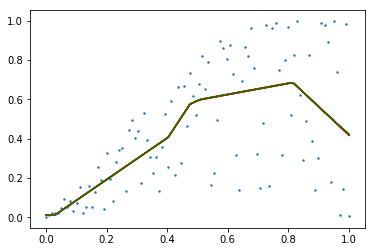

In [180]:
plt.scatter(x, y, s = 2)
for i in range(5):
    plt.plot(x, pred[i], c = 'r')
plt.plot(x, pred_mean, c = 'g')





In [181]:
w0_draw

[array([[-0.6397305 , -0.11773546, -0.54290485, -0.71948785, -0.3888537 ,
         -0.8151191 , -0.3514616 , -0.66546756, -0.61162764, -0.4407161 ,
         -0.36821067, -0.5041183 , -0.19022177, -0.6334102 , -0.44945985,
         -0.6010383 , -0.4069829 , -0.7911164 ,  2.3382232 , -0.5098265 ,
         -0.55893636, -0.5645871 , -0.6143664 , -0.85366946, -0.51321685,
         -0.13027216, -0.59084296, -0.37068802, -0.45616993, -0.4037945 ,
         -0.48447075, -0.468693  , -0.6140524 , -0.68658876, -0.60454464,
         -0.6709549 , -0.5037961 , -0.54206645, -0.14243242, -0.6939148 ,
         -0.18673034, -0.64836264, -0.55447745, -0.61159325, -0.18565449,
         -0.49692985, -0.4600061 , -0.55775696, -0.38006824, -0.9683768 ,
         -0.49069196, -0.52409285, -0.9393391 , -0.32643452, -0.10322304,
         -0.5286195 , -0.65560466, -0.75029266, -0.68175745, -0.18672359,
         -0.50963193, -0.69083315, -0.30502614, -0.8012857 , -0.4341672 ,
         -0.44430724, -0.5313241 , -0.